# **Import** **Libraries**

In [12]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import noisereduce as nr
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from itertools import combinations
from joblib import Parallel, delayed, dump
import logging

# **Load Data**

In [ ]:
    # Set up logging
    logging.basicConfig(level=logging.INFO)

    # Directory path to dataset and labels
    data_dir = r"E:\OneDrive\Desktop\GP\(ORIGINAL)DATASET-HEARTSOUNDS"
    labels = ['abnormal', 'artifact', 'extrahls', 'extrastole', 'murmur', 'normal', 'special cases']

    # Parallelized data loading
    def load_data_parallel(label):
        label_dir = os.path.join(data_dir, label)
        files = os.listdir(label_dir)
        return [[os.path.join(label_dir, file), label] for file in files]

    data = Parallel(n_jobs=-1)(delayed(load_data_parallel)(label) for label in labels)
    data = [item for sublist in data for item in sublist]

    # Convert to DataFrame
    data_df = pd.DataFrame(data, columns=['file_path', 'label'])
    data_df['label'] = data_df['label'].astype('category').cat.codes

In [14]:
# Noise reduction and bandpass filter
def ml_noise_reduction(y, sr, noise_duration=0.5):
    noise_sample = y[:int(noise_duration * sr)]
    y_denoised = nr.reduce_noise(y=y, sr=sr, y_noise=noise_sample)
    return y_denoised

def bandpass_filter(y, sr, low_cut=20, high_cut=500):
    nyquist = 0.5 * sr
    low = low_cut / nyquist
    high = high_cut / nyquist
    b, a = butter(1, [low, high], btype='band')
    return filtfilt(b, a, y)

def preprocess_audio(file_path, target_sr=22050, noise_duration=0.5):
    y, sr = librosa.load(file_path, sr=target_sr)
    y = ml_noise_reduction(y, sr, noise_duration)
    y = bandpass_filter(y, sr)
    y, _ = librosa.effects.trim(y, top_db=20)
    if y.size == 0:
        return np.zeros(target_sr), sr  # Return silence of 1 second
    y = y / np.max(np.abs(y)) if np.max(np.abs(y)) != 0 else y
    return y, sr

# Parallelized audio preprocessing
processed_signals = Parallel(n_jobs=-1)(delayed(preprocess_audio)(row['file_path']) for _, row in data_df.iterrows())
data_df['processed_signal'] = [signal for signal, _ in processed_signals]


# **Feature Extraction**

In [15]:
# Feature extraction
def extract_features(signal, sr):
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=20).mean(axis=1)
    chroma = librosa.feature.chroma_stft(y=signal, sr=sr).mean(axis=1)
    spectral_contrast = librosa.feature.spectral_contrast(y=signal, sr=sr).mean(axis=1)
    zcr = librosa.feature.zero_crossing_rate(y=signal).mean()
    rolloff = librosa.feature.spectral_rolloff(y=signal, sr=sr).mean()
    centroid = librosa.feature.spectral_centroid(y=signal, sr=sr).mean()
    rms_energy = librosa.feature.rms(y=signal).mean()
    return {
        'mfccs': mfccs.flatten(),
        'chroma': chroma.flatten(),
        'spectral_contrast': spectral_contrast.flatten(),
        'zcr': zcr,
        'rolloff': rolloff,
        'centroid': centroid,
        'rms_energy': rms_energy
    }

features_list = Parallel(n_jobs=-1)(delayed(extract_features)(row['processed_signal'], 22050) for _, row in data_df.iterrows())
feature_keys = list(features_list[0].keys())
data_df = pd.concat([data_df, pd.DataFrame(features_list)], axis=1)

# Generate feature combinations
feature_combinations = sum([list(combinations(feature_keys, r)) for r in range(1, len(feature_keys) + 1)], [])


In [16]:
# Define Deep Learning models
def build_dense_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [18]:
# Evaluate models and save all results in a CSV file
dl_results = []
for combination in feature_combinations:
    logging.info(f"Evaluating feature combination (DL): {combination}")
    try:
        # Prepare features and labels
        X = np.array([
            np.concatenate([row[feat] for feat in combination], axis=None)
            for _, row in data_df.iterrows()
        ])
        y = to_categorical(data_df['label'].values, num_classes=len(labels))

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        X_train_reshaped = X_train[..., np.newaxis]
        X_test_reshaped = X_test[..., np.newaxis]

        # Evaluate each deep learning model
        for model_name, model_builder in zip(
            ["Dense NN", "CNN", "LSTM"],
            [build_dense_model, build_cnn_model, build_lstm_model]
        ):
            model = model_builder(
                X_train_reshaped.shape[1:] if model_name != "Dense NN" else X_train.shape[1:],
                len(labels)
            )
            model.fit(
                X_train_reshaped if model_name != "Dense NN" else X_train,
                y_train,
                validation_data=(X_test_reshaped if model_name != "Dense NN" else X_test, y_test),
                epochs=10,
                batch_size=16,
                verbose=0
            )
            test_loss, test_accuracy = model.evaluate(
                X_test_reshaped if model_name != "Dense NN" else X_test, y_test, verbose=0
            )
            # Append results to the list
            dl_results.append({
                'features': combination,
                'model': model_name,
                'accuracy': test_accuracy
            })
    except Exception as e:
        logging.error(f"Error evaluating feature combination (DL): {combination}: {e}")
        # Save error details for debugging
        dl_results.append({
            'features': combination,
            'model': "Error",
            'accuracy': 0.0,
            'error': str(e)
        })

ERROR:root:Error evaluating feature combination (DL): ('zcr',): Computed output size would be negative. Received `inputs shape=(None, 1, 1)`, `kernel shape=(3, 1, 32)`, `dilation_rate=[1]`.
ERROR:root:Error evaluating feature combination (DL): ('rolloff',): Computed output size would be negative. Received `inputs shape=(None, 1, 1)`, `kernel shape=(3, 1, 32)`, `dilation_rate=[1]`.
ERROR:root:Error evaluating feature combination (DL): ('centroid',): Computed output size would be negative. Received `inputs shape=(None, 1, 1)`, `kernel shape=(3, 1, 32)`, `dilation_rate=[1]`.
ERROR:root:Error evaluating feature combination (DL): ('rms_energy',): Computed output size would be negative. Received `inputs shape=(None, 1, 1)`, `kernel shape=(3, 1, 32)`, `dilation_rate=[1]`.
ERROR:root:Error evaluating feature combination (DL): ('zcr', 'rolloff'): Exception encountered when calling Conv1D.call().

Negative dimension size caused by subtracting 3 from 2 for '{{node sequential_95_1/conv1d_30_1/conv

In [19]:
# Convert DL results to DataFrame
dl_results_df = pd.DataFrame(dl_results)
dl_results_df = dl_results_df.sort_values(by='accuracy', ascending=False)

# Save results to a CSV file
results_csv_file = "dl_feature_combinations_results.csv"
dl_results_df.to_csv(results_csv_file, index=False)
print(f"All feature combination results saved to {results_csv_file}")

All feature combination results saved to dl_feature_combinations_results.csv


In [23]:
# Save the best model
best_dl_row = dl_results_df.iloc[0]
best_features = best_dl_row['features']
best_model_name = best_dl_row['model']
best_model_accuracy = best_dl_row['accuracy']

In [25]:
# Re-train the best model with full dataset
X_best = np.array([
    np.concatenate([row[feat] for feat in best_features], axis=None)
    for _, row in data_df.iterrows()
])
y_best = to_categorical(data_df['label'].values, num_classes=len(labels))

X_train, X_test, y_train, y_test = train_test_split(X_best, y_best, test_size=0.3, random_state=42)
X_train_reshaped = X_train[..., np.newaxis]

if best_model_name == "Dense NN":
    best_model = build_dense_model(X_train.shape[1:], len(labels))
elif best_model_name == "CNN":
    best_model = build_cnn_model(X_train_reshaped.shape[1:], len(labels))
elif best_model_name == "LSTM":
    best_model = build_lstm_model(X_train_reshaped.shape[1:], len(labels))

best_model.fit(X_train_reshaped if best_model_name != "Dense NN" else X_train, y_train, epochs=20, batch_size=32)

# Save the trained model, features, and labels
model_file = f"{best_model_name}_best_model_with_features_and_labels.joblib"
dump((best_model, best_features, labels), model_file)
print(f"Best model ({best_model_name}) saved with features and labels in {model_file}")

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.3941 - loss: 9.8528
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6551 - loss: 2.2138
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7226 - loss: 0.8124
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8200 - loss: 0.5789
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7882 - loss: 0.6141
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7819 - loss: 0.6214
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8230 - loss: 0.5147
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8173 - loss: 0.5390
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8253 - loss: 0.5054
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8382 - loss: 0.4756
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8312 - loss: 0.4587
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8412 - l

<>:6: SyntaxWarning: invalid escape sequence '\O'
<>:6: SyntaxWarning: invalid escape sequence '\O'
C:\Users\HP\AppData\Local\Temp\ipykernel_27360\951975088.py:6: SyntaxWarning: invalid escape sequence '\O'
  csv_path = "E:\OneDrive\Desktop\GP\csv\dl_feature_combinations_results.csv"  # Replace with the actual file path
C:\Users\HP\AppData\Local\Temp\ipykernel_27360\951975088.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='model', y='accuracy', data=df, jitter=True, size=8, alpha=0.7, palette='viridis')


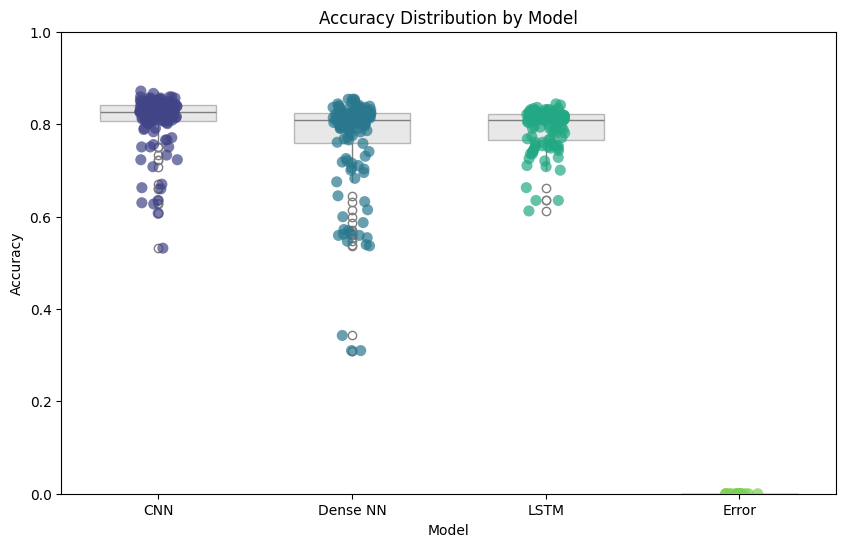

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the CSV file
csv_path = "E:\OneDrive\Desktop\GP\csv\dl_feature_combinations_results.csv"  # Replace with the actual file path
df = pd.read_csv(csv_path)



plt.figure(figsize=(10, 6))
sns.stripplot(x='model', y='accuracy', data=df, jitter=True, size=8, alpha=0.7, palette='viridis')
sns.boxplot(x='model', y='accuracy', data=df, color='lightgrey', width=0.6, showcaps=False, 
            boxprops={'zorder': -1, 'alpha': 0.5})
plt.title("Accuracy Distribution by Model")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

plt.show()
